# <div align="center"><b> Desafio 5 - Procesamiento del lenguaje Natural - CEIA </b></div>


<div align="right">📝 <em><small><font color='Gray'>Nota:</font></small></em></div>

<div align="right"> <em><small><font color='Gray'> La funcionalidad de visualización de jupyter notebooks en <a href="https://github.com/" target="_blank">github</a> es solamente un preview.</font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Para mejor visualización se sugiere utilizar el visualizador recomndado por la comunidad: <a href="https://nbviewer.org/" target="_blank">nbviewer</a></font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Puedes a acceder al sigiente enlace para ver este notebook en dicha página: <a href="https://nbviewer.org/github/brunomaso1/uba-ceia/blob/ceia-nlp/ceia-nlp/Desafio%205.ipynb">Desafio 5</a></font></small></em> </div>


---


In [45]:
# Descargamos la carpeta con archivos auxiliares (Colab)
# %pip install gdown
# !gdown https://drive.google.com/drive/folders/1hNPqr6g3opu9u-UwnngVcyxUUzfmKZdT?usp=sharing --folder

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>


<div align="center"><img src="./resources/Desafio_5_portada.jpeg" width="600" alt="Figura 1: AA data scientist is sitting in front of a computer screen, which is the focal point of the image. The lighting is dark and moody, with a blue hue. The computer screen displays a visualization of a BERT model. The scientist is intently analyzing Google's Apps critics with BERT, as the blue hue of the lighting creates a sense of focus and concentration. - Generada con Microsoft Image generator"></div>

<div align="center"><small><em>Figura 1: A data scientist is sitting in front of a computer screen, which is the focal point of the image. The lighting is dark and moody, with a blue hue. The computer screen displays a visualization of a BERT model. The scientist is intently analyzing Google's Apps critics with BERT, as the blue hue of the lighting creates a sense of focus and concentration. - Generada con Microsoft Image generator</em></small></div>


<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | Desafío 5 - NLP - FIUBA               |
| --------------- | ------------------------------------- |
| **Descrpción**  | BERT Sentiment Analysis               |
| **Integrantes** | Bruno Masoller (brunomaso1@gmail.com) |

</div>


✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋


In [141]:
import os, random

# Librería para trabajar con transformers (en este caso, BERT)
from transformers import (
    TFBertModel,
    logging,
    InputExample,
    InputFeatures,
    BertTokenizer,
)

# Retro-compatibilidad con la librería de transformers. Si usas Keras 3 explota todo.
from tf_keras import Model
from tf_keras.layers import Input, Dropout, Dense
from tf_keras.metrics import F1Score

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import gdown
import pandas as pd
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np

from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [47]:
RANDOM_SEED = 42
EPOCHS = 1
BATCH_SIZE = 32

DRIVE_APPS_URL = "https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download&confirm=t"
APPSCSV_PATH = "resources/apps.csv"

DRIVE_REVIEWS_URL = "https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t"
REVIEWS_PATH = "resources/reviews.csv"

PLOT_MODEL_PATH = "resources/bert.png"

random.seed(RANDOM_SEED)
logging.set_verbosity_error()

## Consigna del desafío


<em><p>

BERT consume una secuencia de tokens (términos tokenizados) y devuelve una secuencia de embeddings, que se agrupan en dos estructuras: `pooler_output` y `last_hidden_state`:

- `pooler_output`: Condensa información de toda la secuencia (se puede utilizar como una vectorización de todo el documento). Shape: $(cant_seq, embb_dim)$
- `last_hidden_state`: Devuelve el embedding asociado a cada posición de los tokens de entrada contextualizados. Shape: $(cant_seq, cant_tok, embb_dim)$

El objetivo para análisis de sentimientos, es clasificar un conjunto de documentos (corpus) en clases, utilizando la similitud entre estos vectores contextualizados. En donde, se arma una base de datos con los documentos vectorizados por BERT, luego también se vectorizan las clases y utilizando la similitud entre vectores (ej: similitud de coseno), se obtienen que vector de clase está más cerca de cada documento.

En este caso, se estaría utilizando un modelo como clasificador, sin haberlo entrenado explicitamente para dicha tarea. Si, aparte de esto, se le agrega una capa para clasificar según la clase y se entrena (fine-tuning), se obtiene un clasificador específico mediante transfer learning.

<strong>Este desfío consiste justamente realizar experimentos para los dos casos (con fine-tuning -entrenamiento grueso- y sin fine-tuning), en donde se intenta clasificar reviews de aplicaciones de Google en diferentes clases de sentimientos.</strong>

</p></em>


## Resolución


### Análisis de datos


_Para este desafío se utiliza como dataset las críticas de Google Apps en formato csv._


🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Descarga un archivo del Drive utilizando Gdown</p></font></em>


In [48]:
def download_from_drive(download_url, output_path):
    """
    Descarga un archivo desde Google Drive utilizando gdown si no existe en el output_path.

    :param drive_url: URL del archivo en Google Drive o su ID
    :param output_path: Ruta de destino donde se guardará el archivo descargado
    """
    # Verificamos si el archivo ya existe para evitar descargas innecesarias
    if os.path.exists(output_path):
        print(
            f"El archivo ya existe en {output_path}. No es necesario descargarlo nuevamente."
        )
        return

    # Descargamos el archivo ya que no existe en output_path
    try:
        print(f"Descargando el archivo desde Google Drive en {output_path}")
        gdown.download(download_url, output_path, quiet=False)
    except e:
        raise ImportError(f"No se pudo descargar el archivo. Error: {e}")

_Descargamos los datos del Drive:_


In [49]:
download_from_drive(DRIVE_APPS_URL, APPSCSV_PATH)
download_from_drive(DRIVE_REVIEWS_URL, REVIEWS_PATH)

El archivo ya existe en resources/apps.csv. No es necesario descargarlo nuevamente.
El archivo ya existe en resources/reviews.csv. No es necesario descargarlo nuevamente.


_Observamos el conjunto:_


In [50]:
df = pd.read_csv(REVIEWS_PATH)
# Mostramos el DataFrame
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


_Cantidad de datos:_


In [51]:
print(f"Cantidad de críticas: {len(df)}")

Cantidad de críticas: 15746


_Análisis previo de los datos:_


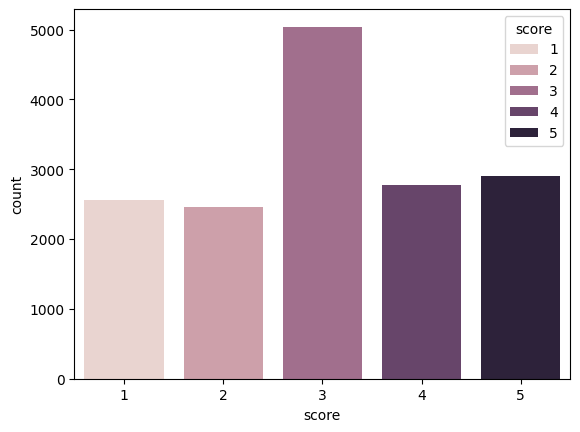

In [52]:
sns.countplot(df, x="score", hue="score")
plt.show()

⚠️ <em><font color='gold'>Problemas detectados:</font></em>
<em><font color='gold'><p>Un punto importante a destacar, es el desbalanceo de clases, especialmente con respecto a la clase 3. Para solucionar este problema utilizaremos <strong>random sampling</strong>, en este caso la estrategia elegida es $undersampling$</p></font></em>


_Aplicamos $undersampling$, renombramos la columna y cambiamos los índices a que empiecen desde 0:_


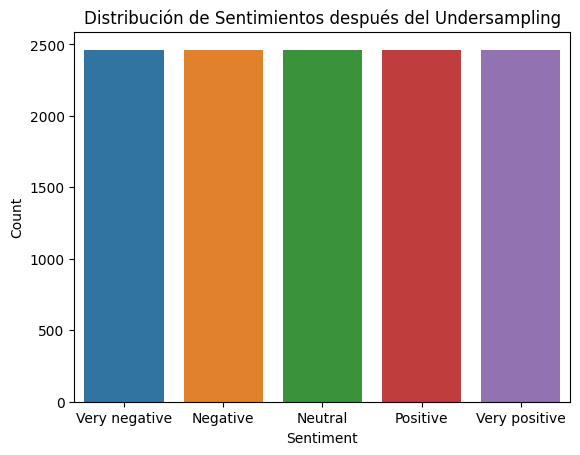

In [53]:
# Diccionario para mapear cada score a una clase descriptiva
score_dict = {
    0: "Very negative",
    1: "Negative",
    2: "Neutral",
    3: "Positive",
    4: "Very positive",
}

# Separar características (X) y la clase objetivo (y)
X = df.drop(columns=["score"])
y = df["score"]

# Instanciar el RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy="auto", random_state=RANDOM_SEED)

# Aplicar el undersampling
X_resampled, y_resampled = rus.fit_resample(X, y)

# Concatenar las características re-muestreadas con la clase objetivo
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Le restamos 1 a la columna score para que arranque en 0 el índice.
df_resampled["score"] = df_resampled["score"] - 1

# Mapear los valores numéricos a las clases descriptivas
df_resampled["score_class"] = df_resampled["score"].map(score_dict)
df_resampled.rename(columns={"score": "sentiment"}, inplace=True)

# Mostrar un gráfico de barras de las clases después del undersampling
sns.countplot(data=df_resampled, x="score_class", hue="score_class")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribución de Sentimientos después del Undersampling")
plt.show()

In [54]:
print(f"Cantidad datos: {len(df_resampled)}")

Cantidad datos: 12310


_Obtenemos las sentencias:_


In [55]:
sentences = df_resampled["content"].values
print(f"Shape sentencias: {sentences.shape}")
sentences[:3]

Shape sentencias: (12310,)


array(["I purchased the pro version in my motorola g5 plus , than uninstalled it, now I can't even get that purchase back! I understand it happening between two different devices, but I'm still using same device. Please help with it",
       'Used it until simple backup was premiumized. Restore wont work between different versions unless you modi-hack the file. Author would not tell you that you can do it though if you ask his help ! . Restore dont recognize my backup file at all so all my lists are basically inaccessible now. Will never install this again and I suggest anyone who values his data not to !',
       "Auto-fail only works if you go to each task? That's not auto fail. Makes no \nsense. Might as well go back to Life RPG. that feature was the only reason \nI even tried this. Subscription model ridiculous. Why would I pay a MONTHLY \nfee for some icons? They are helpful icons & necessary mostly, but that's \njust ridiculously expensive for some icons. A one time fee is reason

_Visualizamos la distribución de los tamaños de las sentencias:_


Valor medio: 139.0
Percentil 90: 419.0


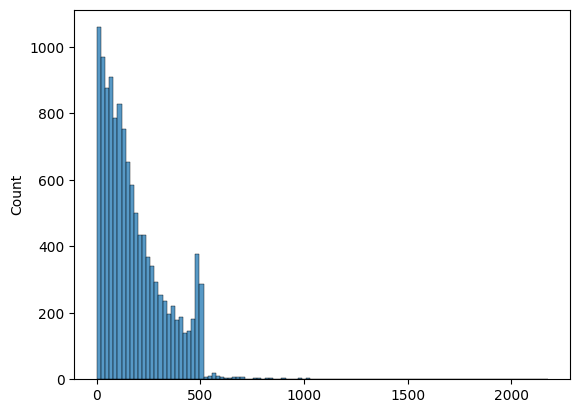

In [56]:
sentences_lenght = [len(sentence) for sentence in sentences]
sns.histplot(sentences_lenght, bins=int(sqrt(len(sentences_lenght))))
print(f"Valor medio: {np.median(sentences_lenght)}")
print(f"Percentil 90: {np.percentile(sentences_lenght, q=90)}")

_Definimos el `max_length`_


📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'><p>BERT soporta un máximo de $512$.</p></font></em>


In [57]:
max_length = 140

_Obtenemos el target:_


In [58]:
y = df_resampled["sentiment"].values
print(f"Shape y antes: {y.shape}")
y = to_categorical(y)
print(f"Shape y después: {y.shape}")
output_shape = y.shape[1]
print(f"output_shape: {output_shape}")
print(y[:3])

Shape y antes: (12310,)
Shape y después: (12310, 5)
output_shape: 5
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


### Modelo


_Para definir el modelo, utilizaremos el encoder de BERT, lo dejaremos fino (no entrenable) y se le agregarán algunas capas densas para la clasificación:_


In [59]:
# Importamos el modelo
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Seteamos el modelo como no entrenable.
bert_model.bert.trainable = False

# Creamos las capas de entrada.
input_ids = Input(shape=(max_length,), dtype="int32", name="input_ids")
attention_mask = Input(shape=(max_length,), dtype="int32", name="attention_mask")

# Conectamos las capas de entrada con el encoder.
outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

# Pasamos por una capa de dropout
x = Dropout(0.2)(pooled_output)

# Definimos la capa densa final con la cantidad de salida de nuestras clases.
output = Dense(output_shape, activation="softmax")(x)

# Definimos el modelo y compilamos.
base_model = Model(inputs=[input_ids, attention_mask], outputs=output)
base_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", F1Score(average="macro")],
)
base_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                     

📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'><p>Los parámetros entrenables, serían únicamente los de la capa densa. En este caso, dado que son 5 clases, y la entrada es el tamaño de embbeding de BERT, o sea, 768, la cantidad de parámetros entrenables es $768 * 5 + 5 = 3845$ (el $+5$ corresponde a los bias de las 5 neuronas)</p></font></em>


_Imprimimos el modelo:_


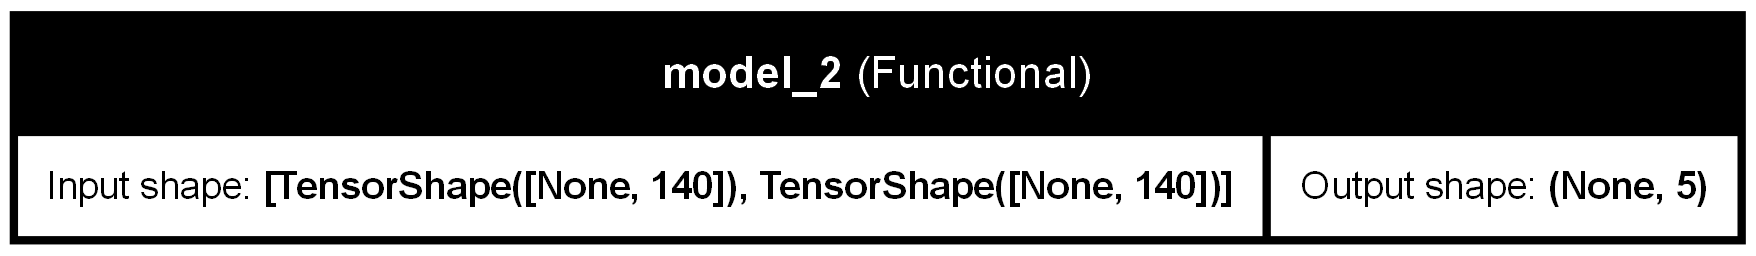

In [60]:
plot_model(base_model, to_file=PLOT_MODEL_PATH, show_shapes=True, show_layer_names=True)

### Entrenamiento


🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Permite graficar los resultados desde el histórico de keras.</p></font></em>


In [61]:
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history["accuracy"]) + 1)
    sns.lineplot(x=epoch_count, y=history.history["accuracy"], label="train")
    sns.lineplot(x=epoch_count, y=history.history["val_accuracy"], label="valid")
    plt.show()

#### Data generator


_El objetivo es obtener un dataset del cual podamos ir generando los datos con las clases `InputExample` y `InputFeatures`, al estilo del <ins>DataSet</ins> y <ins>DataLoader</ins> de $Pytorch$. O sea, ir pasandole al modelo en tiempo de entrenamiento, los datos "on the fly" (lo que implica no cargar todo el dataset en memoria)._


_Entonces, del dataset original, accedemos a los datos por índices mezclados aleatoriamente (separamos los datos en train/test/val):_


In [62]:
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(
    indices, test_size=0.2, random_state=RANDOM_SEED
)
idx_train, idx_val = train_test_split(
    idx_train_val, test_size=0.2, random_state=RANDOM_SEED
)

_Cantidad de datos:_


In [63]:
print(f"Cantidad datos TRAIN: {idx_train.shape[0]}")
print(f"Cantidad datos TEST: {idx_test.shape[0]}")
print(f"Cantidad datos VAL: {idx_val.shape[0]}")

Cantidad datos TRAIN: 7878
Cantidad datos TEST: 2462
Cantidad datos VAL: 1970


In [64]:
# TODO: Eliminar esto
idx_train = idx_train[:50]
idx_test = idx_test[:20]
idx_val = idx_val[:10]

_Instanciamos el tokenizador:_


In [111]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

_Luego, definimos una función generadora (mediante `yield`), que brinde datos a demanda:_


📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'><p>

BERT puede consumir dos secuencias de texto, separadas por un separador, con el objetivo de decidir si los textos están relacionados. Por eso, la clase `InputExample` está preparada para recibir dos textos (`text_a` y `text_b`), pero se puede utilizar solo uno de dichos textos. También recibe el label asociado a dicho ejemplo. En la función `convert_data_to_examples` se realiza eso tanto para el conjunto de entrenamiento como para el de validación.

La función `convert_examples_to_tf_dataset`, realiza la conversión de `InputExamples` a `InputFeatures`, que son los que termina recibiendo el modelo de BERT. También devuelve una función generadora, para devolver datos a <ins>demanda</ins>.

</p></font></em>


In [66]:
def convert_data_to_examples(text, labels, idx_train, idx_val):
    """Arma un 'InputExample' para los datos de entrenamientos y validación"""
    train_InputExamples = [
        InputExample(guid=None, text_a=text[i], text_b=None, label=labels[i])
        for i in idx_train
    ]

    validation_InputExamples = [
        InputExample(guid=None, text_a=text[i], text_b=None, label=labels[i])
        for i in idx_val
    ]

    return train_InputExamples, validation_InputExamples


def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512):
    """
    Transforma los datos de entrada en tensores de:
        - input_ids --> token_id
        - attention_mask
        - token_type
    """
    features = []

    # Este ciclo convierte los InputExamples en InputFeatures, lo que implica
    # tokenizar, obtener la máscara de atención y los imputs id.
    # InputFeatures se crea con los inputs_id, attention_mask, label.
    for e in examples:
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,  # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding="max_length",  # pads to the right by default
            truncation=True,
        )

        input_ids, attention_mask = (
            input_dict["input_ids"],
            input_dict["attention_mask"],
        )

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    # Función generadora para no levantar todos los datos en un instante
    def gen():
        for f in features:
            # yield implica devolver un item de features cada vez que se llama.
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    # Devuelve el generador y devuelve un tipo Dataset de tensorflow, creado desde la función from_generator,
    # que recibe el generador, y los tipos.
    # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator
    return tf.data.Dataset.from_generator(
        # tf dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({"input_ids": "int32", "attention_mask": "int32"}, "float32"),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
            },
            tf.TensorShape([output_shape]),
        ),
    )

_Una vez definida la función para obtener un `tf.data.Dataset` desde un generador, lo instanciamos._


In [67]:
# Obtengo los ejemplos.
train_InputExamples, validation_InputExamples = convert_data_to_examples(
    sentences, y, idx_train, idx_val
)

# Obtengo el tf.data.Dataset para entrenamiento.
train_data: tf.data.Dataset = convert_examples_to_tf_dataset(
    list(train_InputExamples), bert_tokenizer, max_length=max_length
)

# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
train_data = train_data.shuffle(100).batch(BATCH_SIZE)

# Obtengo el tf.data.Dataset para validacion.
validation_data: tf.data.Dataset = convert_examples_to_tf_dataset(
    list(validation_InputExamples), bert_tokenizer, max_length=max_length
)
validation_data = validation_data.batch(BATCH_SIZE)

#### BERT Base model

*Primeramente, entrenaremos el modelo sin hacer fine-tuning:*

In [70]:
# TODO: Borrar esto
EPOCHS = 10

In [71]:
steps_per_epoch = len(idx_train) // BATCH_SIZE
validation_steps = len(idx_val) // BATCH_SIZE

base_model_history = base_model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

Epoch 1/10


2/2 [==============================] - 14s 7s/step - loss: 1.7294 - accuracy: 0.2400 - f1_score: 0.1417 - val_loss: 1.8497 - val_accuracy: 0.2000 - val_f1_score: 0.0727
Epoch 2/10
2/2 [==============================] - 18s 9s/step - loss: 1.7545 - accuracy: 0.2800 - f1_score: 0.1750 - val_loss: 1.9953 - val_accuracy: 0.2000 - val_f1_score: 0.0667
Epoch 3/10
2/2 [==============================] - 18s 8s/step - loss: 1.6804 - accuracy: 0.2400 - f1_score: 0.1660 - val_loss: 2.0120 - val_accuracy: 0.1000 - val_f1_score: 0.0667
Epoch 4/10
2/2 [==============================] - 18s 8s/step - loss: 1.7406 - accuracy: 0.2600 - f1_score: 0.1773 - val_loss: 1.9212 - val_accuracy: 0.1000 - val_f1_score: 0.0800
Epoch 5/10
2/2 [==============================] - 17s 9s/step - loss: 1.6087 - accuracy: 0.2800 - f1_score: 0.2265 - val_loss: 1.7744 - val_accuracy: 0.2000 - val_f1_score: 0.2000
Epoch 6/10
2/2 [==============================] - 19s 9s/step - loss: 1.6935 - accuracy: 0.2600 - f1_score: 0.2

*Graficamos los resultados:*

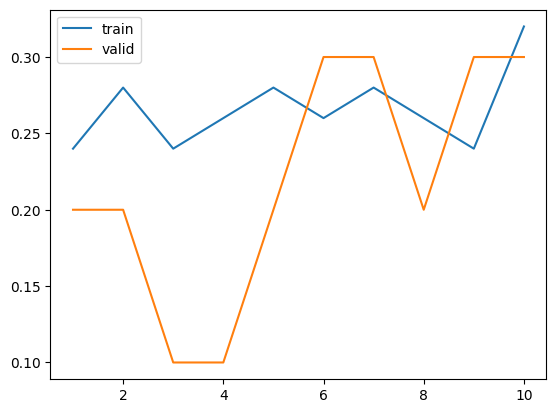

In [72]:
plot_train_metrics(base_model_history)

*Probamos los resultados con el cojunto de test:*

In [137]:
# Obtenemos las sentencias de test.
pred_sentences = [sentences[i] for i in idx_test]

tf_batch = bert_tokenizer.batch_encode_plus(
    pred_sentences,
    add_special_tokens=True,
    max_length=max_length,  # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    padding="max_length",  # pads to the right by default
    truncation=True,
    return_tensors='tf'
)

# Dividimos en input y target.
X_test = [tf_batch["input_ids"], tf_batch["attention_mask"]]
y_test = y[idx_test]

# Realizamos la predicción
y_hat_prob = base_model.predict(X_test)
print(f"Salida de la predicción:\n {y_hat_prob[:3]}")

# Nos quedamos con la clase que tiene la probabilidad más alta para cada documento
y_hat = np.argmax(y_hat_prob, axis=1)  # Softmax
print(f"\nLuego de softmax:\n {y_hat[:3]}")

# Podríamos haber calculado la exactitud con el vector anterior, pero utilizamos el método evaluate
# de los modelos de tensorflow.
scores = base_model.evaluate(X_test, y_test)
print(f"\nExactitud del modelo: {scores[1]}")

1/1 [==============================] - 5s 5s/step
Salida de la predicción:
 [0.14604594 0.39759022 0.13515575 0.237648   0.08356017]

Luego de softmax:
 [1 3 1]
1/1 [==============================] - 6s 6s/step - loss: 1.6298 - accuracy: 0.2500 - f1_score: 0.1321

Exactitud del modelo: 0.25


*También podemos realizar una matriz de confusión para mejor obaservación (notar que son 5 clases, la matriz es de 5x5):*

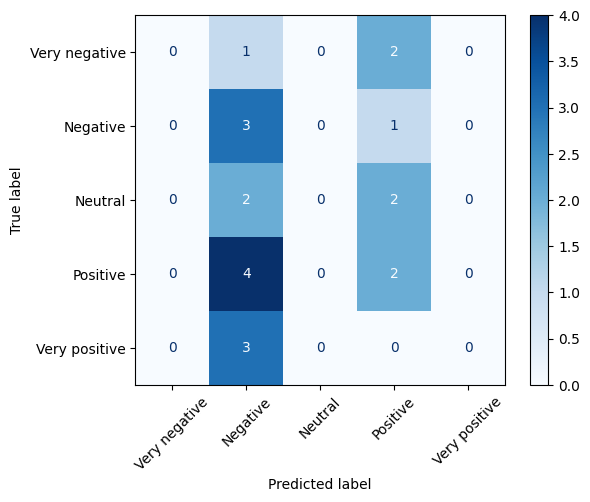

In [140]:
# Obtenemos la matriz de confusión.
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)

# Mapeamos los números a los nombres de las clases.
labels = [score_dict[i] for i in range(len(score_dict))]

# Creamos la visualización de la matriz de confusión con los nombres de las clases.
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Mostramos la matriz de confusión con los labels.
cmd.plot(cmap=plt.cm.Blues)

# Rotamos las etiquetas del eje x en 45 grados.
plt.xticks(rotation=45)

# Mostramos el gráfico.
plt.show()

#### BERT Fine tuning

*Para probar el modelo fine-tuning, tenemos que poner las capas como entrenables:*

In [ ]:
fine_tuned_model = base_model

for layer in fine_tuned_model.layers:
    layer.trainable = True

# Como es fine tuning, se recomienda utilizar al menos un learnig rate 100 veces menor
# que el original.
base_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss="categorical_crossentropy",
    metrics=["accuracy", F1Score(average="macro")],
)
base_model.summary()

*Realizamos el entrenamiento:*

In [ ]:
steps_per_epoch = len(idx_train) // BATCH_SIZE
validation_steps = len(idx_val) // BATCH_SIZE

fine_tuned_model_history = fine_tuned_model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

*Graficamos los resultados:*

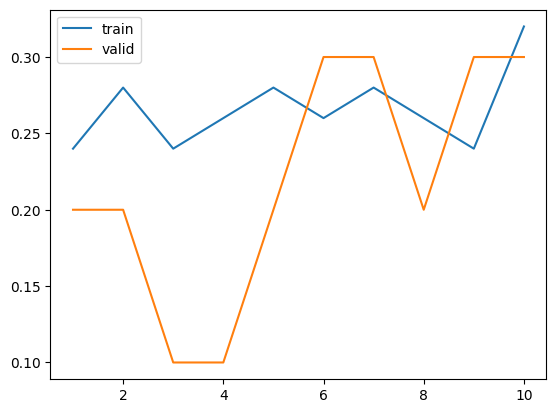

In [ ]:
plot_train_metrics(fine_tuned_model_history)

*Probamos los resultados con el cojunto de test:*

In [ ]:
# Obtenemos las sentencias de test.
pred_sentences = [sentences[i] for i in idx_test]

tf_batch = bert_tokenizer.batch_encode_plus(
    pred_sentences,
    add_special_tokens=True,
    max_length=max_length,  # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    padding="max_length",  # pads to the right by default
    truncation=True,
    return_tensors='tf'
)

# Dividimos en input y target.
X_test = [tf_batch["input_ids"], tf_batch["attention_mask"]]
y_test = y[idx_test]

# Realizamos la predicción
y_hat_prob = fine_tuned_model.predict(X_test)
print(f"Salida de la predicción:\n {y_hat_prob[:3]}")

# Nos quedamos con la clase que tiene la probabilidad más alta para cada documento
y_hat = np.argmax(y_hat_prob, axis=1)  # Softmax
print(f"\nLuego de softmax:\n {y_hat[:3]}")

# Podríamos haber calculado la exactitud con el vector anterior, pero utilizamos el método evaluate
# de los modelos de tensorflow.
scores = fine_tuned_model.evaluate(X_test, y_test)
print(f"\nExactitud del modelo: {scores[1]}")

1/1 [==============================] - 5s 5s/step
Salida de la predicción:
 [0.14604594 0.39759022 0.13515575 0.237648   0.08356017]

Luego de softmax:
 [1 3 1]
1/1 [==============================] - 6s 6s/step - loss: 1.6298 - accuracy: 0.2500 - f1_score: 0.1321

Exactitud del modelo: 0.25


*También podemos realizar una matriz de confusión para mejor obaservación (notar que son 5 clases, la matriz es de 5x5):*

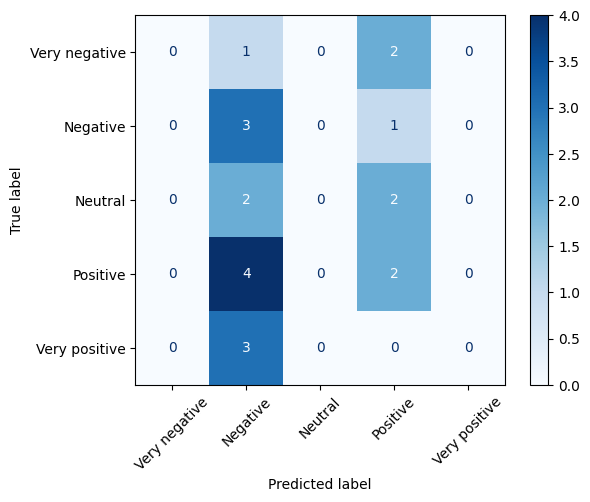

In [ ]:
# Obtenemos la matriz de confusión.
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)

# Mapeamos los números a los nombres de las clases.
labels = [score_dict[i] for i in range(len(score_dict))]

# Creamos la visualización de la matriz de confusión con los nombres de las clases.
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Mostramos la matriz de confusión con los labels.
cmd.plot(cmap=plt.cm.Blues)

# Rotamos las etiquetas del eje x en 45 grados.
plt.xticks(rotation=45)

# Mostramos el gráfico.
plt.show()

#### Generalización

*Finalmente, podemos probar como generaliza el modelo:*

In [ ]:
text = "I love the lord of the rings!"

# Tokenizamos el texto
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length,
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True,
    truncation=True,
    return_tensors="tf",
)

# Preparamos los inputs para la predicción
X_ensayo = [tf_batch["input_ids"], tf_batch["attention_mask"]]

# Realizamos la predicción
y_prob_ensayo = fine_tuned_model.predict(X_ensayo)

# Obtenemos la clase con la probabilidad más alta
y_prob = np.argmax(y_prob_ensayo, axis=1)

# Imprimimos la clasificación utilizando tu diccionario de etiquetas
print("Clasificación: ", score_dict[int(y_prob)])